In [ ]:
!pip install PyMySQL

     |████████████████████████████████| 43 kB 1.1 MB/s 


In [ ]:
import pymysql

In [ ]:
occupancy_db = pymysql.connect(
    user='datacollection', 
    passwd='collection2021!@', 
    host='121.156.90.144', 
    db='db_datacollection', 
    charset='utf8'
)

In [ ]:
cursor = occupancy_db.cursor(pymysql.cursors.DictCursor)

In [ ]:
sql = "Show Tables;"
cursor.execute(sql)
show = cursor.fetchall()
show

[{'Tables_in_db_datacollection': 'dc_building'},
 {'Tables_in_db_datacollection': 'dc_device'},
 {'Tables_in_db_datacollection': 'dc_floor'},
 {'Tables_in_db_datacollection': 'dc_long_term'},
 {'Tables_in_db_datacollection': 'dc_people_cnt'},
 {'Tables_in_db_datacollection': 'dc_pro_mode_define'},
 {'Tables_in_db_datacollection': 'dc_pro_module'},
 {'Tables_in_db_datacollection': 'dc_sensor'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_arduino_1'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_arduino_1_name'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_composite_1'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_temp_camera_1'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_temp_camera_info'},
 {'Tables_in_db_datacollection': 'dc_sensor_define'},
 {'Tables_in_db_datacollection': 'dc_server'},
 {'Tables_in_db_datacollection': 'dc_short_term'},
 {'Tables_in_db_datacollection': 'dc_spot'},
 {'Tables_in_db_datacollection': 'dc_unit_define'},
 {'Tables_in_db_datacollec

In [ ]:
sql = "SELECT sdata_credate, sdata_co2 FROM vw_data_composite WHERE sdata_modbus_id=1;"
cursor.execute(sql)
data = cursor.fetchall()

In [ ]:
import pandas as pd

data = pd.DataFrame(data)

In [ ]:
data.to_csv('occupancy_co2_20220120.csv')
# incom.to_csv('occupancyIO_20211117.csv')

In [ ]:
composite_df = data
composite_df['sdata_credate'] = pd.to_datetime(composite_df['sdata_credate'])
composite_df.set_index('sdata_credate', inplace=True)
composite_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1605632 entries, 2021-05-25 14:13:29 to 2022-01-13 12:53:29
Data columns (total 1 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sdata_co2  1605632 non-null  float64
dtypes: float64(1)
memory usage: 24.5 MB


In [ ]:
composite_df=composite_df.loc['2021-10-07 00:00:00' :]

In [ ]:
composite_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 842813 entries, 2021-10-07 00:00:09 to 2022-01-13 12:53:29
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sdata_co2  842813 non-null  float64
dtypes: float64(1)
memory usage: 12.9 MB


In [ ]:
composite_df.head()

,sdata_co2
sdata_credate,
2021-10-07 00:00:09,614.0
2021-10-07 00:00:19,614.0
2021-10-07 00:00:29,613.0
2021-10-07 00:00:39,614.0
2021-10-07 00:00:49,613.0


# 재실 데이터를 제외한 센서 데이터 그래프
- 온도, 습도, 이산화탄소 농도
- 온, 습도가 가장 관련성 높음
- 이산화탄소 농도와 온도도 관련성이 있음

In [ ]:
composite_df = composite_df.resample('1T').first()
composite_df.fillna(composite_df.mean(),inplace=True)
composite_df.info()
composite_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 141894 entries, 2021-10-07 00:00:00 to 2022-01-13 12:53:00
Freq: T
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sdata_co2  141894 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


,sdata_co2
sdata_credate,
2021-10-07 00:00:00,614.0
2021-10-07 00:01:00,613.0
2021-10-07 00:02:00,617.0
2021-10-07 00:03:00,618.0
2021-10-07 00:04:00,618.0
...,...
2022-01-13 12:49:00,607.0
2022-01-13 12:50:00,607.0
2022-01-13 12:51:00,605.0


## 센서 데이터 1분 주기로 샘플링한 추세 그래프
- 온도

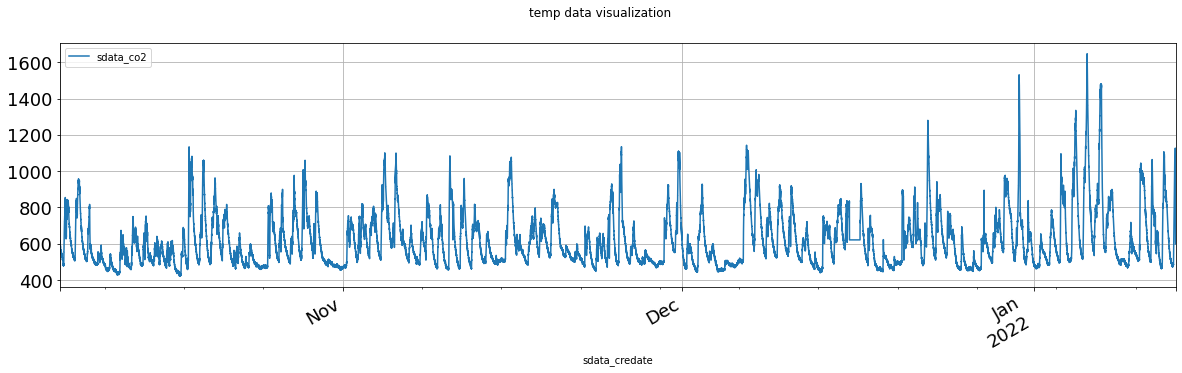

In [ ]:
import matplotlib.pyplot as plt

composite_df.plot(subplots=True, grid=True, 
           figsize=(20, 4), fontsize=18,
           title='co2 data visualization')
plt.show()

## 온도 데이터로 단변량 예측

In [ ]:
from keras.models import load_model
import numpy as np

In [ ]:
# 재실밀도 데이터
df = composite_df
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
co2_w1 = WindowGenerator(input_width=50, label_width=1, shift=50,
                         label_columns=['sdata_co2'])

In [ ]:
co2_w2 = WindowGenerator(input_width=10, label_width=1, shift=1,
                         label_columns=['sdata_co2'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
import tensorflow as tf

# Stack three slices, the length of the total window:
co2_window = tf.stack([np.array(train_df[:co2_w2.total_window_size]),
                           np.array(train_df[100:100+co2_w2.total_window_size]),
                           np.array(train_df[200:200+co2_w2.total_window_size])])

co2_inputs, co2_labels = co2_w2.split_window(co2_window)

print('Temperature shapes are: (batch, time, features)')
print(f'Window shape: {co2_window.shape}')
print(f'Inputs shape: {co2_inputs.shape}')
print(f'labels shape: {co2_labels.shape}\n')

Temperature shapes are: (batch, time, features)
Window shape: (3, 11, 1)
Inputs shape: (3, 10, 1)
labels shape: (3, 1, 1)



In [ ]:
co2_w2.example = co2_inputs, co2_labels

In [ ]:
# 온도
def co2_plot(self, model=None, plot_col='sdata_co2', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(20, 10))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [1m]')

WindowGenerator.co2_plot = co2_plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
co2_w2.train.element_spec

(TensorSpec(shape=(None, 10, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

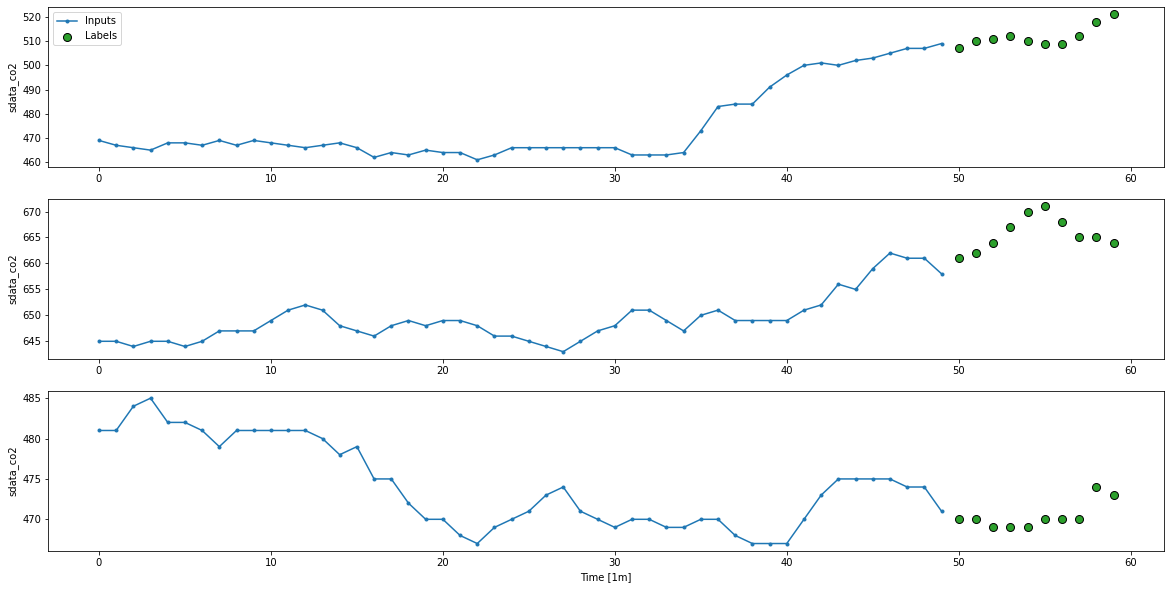

In [ ]:
OUT_STEPS=10
co2_multi_window = WindowGenerator(input_width=50,
                                   label_width=OUT_STEPS,
                                   shift=OUT_STEPS)

co2_multi_window
co2_multi_window.co2_plot()

In [ ]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### 온도

Epoch 1/100
3103/3103 [==============================] - 175s 56ms/step - loss: 289559.5312 - mean_absolute_error: 518.4896 - val_loss: 210043.0625 - val_mean_absolute_error: 435.2569
Epoch 2/100
3103/3103 [==============================] - 176s 57ms/step - loss: 138191.4688 - mean_absolute_error: 343.2481 - val_loss: 91927.0000 - val_mean_absolute_error: 267.0811
Epoch 3/100
3103/3103 [==============================] - 170s 55ms/step - loss: 53357.7188 - mean_absolute_error: 184.0405 - val_loss: 34273.8203 - val_mean_absolute_error: 128.2672
Epoch 4/100
3103/3103 [==============================] - 175s 56ms/step - loss: 21654.2070 - mean_absolute_error: 104.3209 - val_loss: 20478.8750 - val_mean_absolute_error: 100.4410
Epoch 5/100
3103/3103 [==============================] - 172s 55ms/step - loss: 14870.4355 - mean_absolute_error: 90.8666 - val_loss: 14142.3838 - val_mean_absolute_error: 76.3826
Epoch 6/100
3103/3103 [==============================] - 175s 57ms/step - loss: 9954.0293

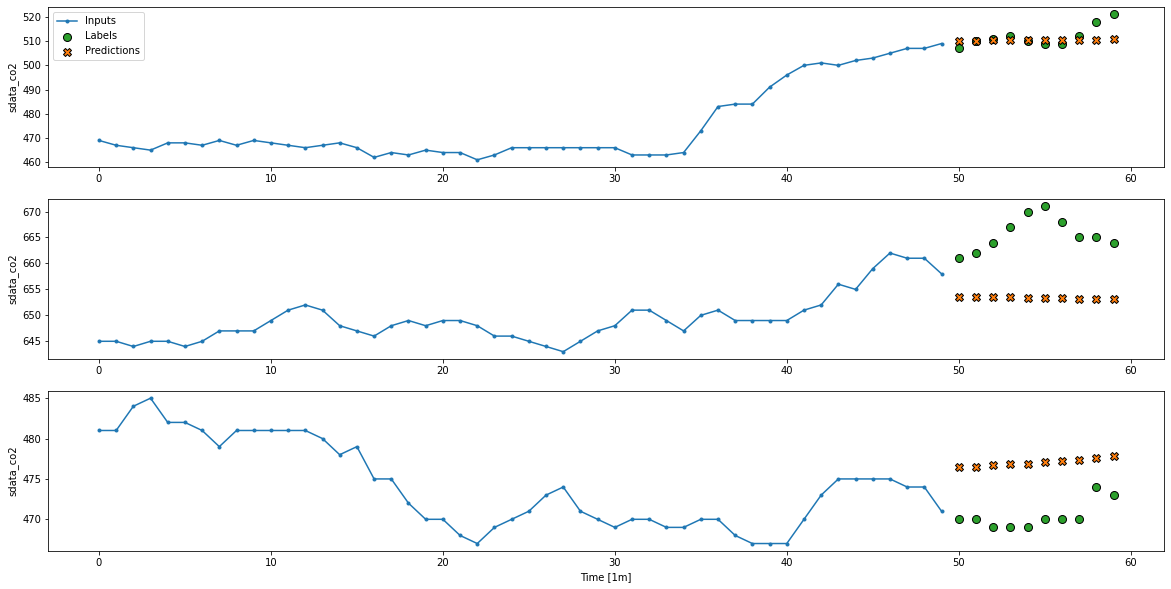

In [ ]:
co2_multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

co2_history = compile_and_fit(co2_multi_lstm_model, co2_multi_window)

co2_multi_val_performance = {}
co2_multi_performance = {}
co2_multi_val_performance['LSTM'] = co2_multi_lstm_model.evaluate(co2_multi_window.val)
co2_multi_performance['LSTM'] = co2_multi_lstm_model.evaluate(co2_multi_window.test, verbose=0)

co2_multi_window.co2_plot(co2_multi_lstm_model)

In [ ]:
co2_multi_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 reshape_1 (Reshape)         (None, 10, 1)             0         
                                                                 
Total params: 67,850
Trainable params: 67,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
co2_multi_lstm_model.evaluate(co2_multi_window.test)

442/442 [==============================] - 9s 20ms/step - loss: 7722.6904 - mean_absolute_error: 29.7596


[7722.6904296875, 29.75958824157715]

In [ ]:
print('_________________________________________________________________')
print('Model evaluate')
print('=================================================================')
print('Loss: ', co2_multi_performance['LSTM'][0])
print('MAE(Mean Absolute Error): ', co2_multi_performance['LSTM'][1])
print('=================================================================')

_________________________________________________________________
Model evaluate
Loss:  7722.6923828125
MAE(Mean Absolute Error):  29.75959587097168


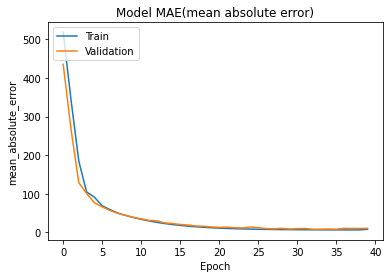

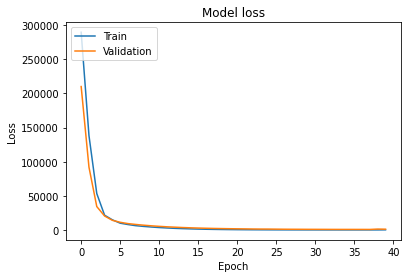

In [ ]:
# 6 훈련 과정 시각화 (MAE)
plt.plot(co2_history.history['mean_absolute_error'])
plt.plot(co2_history.history['val_mean_absolute_error'])
plt.title('Model MAE(mean absolute error)')
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(co2_history.history['loss'])
plt.plot(co2_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
co2_multi_lstm_model.save('co2_multi_lstm_model.h5')